# Estimating $U_{\rm eq}(c)$ from pOCV data
Using [Dandeliion simulation data.](https://simulation.dandeliion.com/legacy/simulation/?id=d91db0e5-e0bb-4391-936c-50c69f267c24) for LGM50 cathode half-cell, driven by galvanostatic $C/20$ charge and discharge.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from IPython.display import display, clear_output, HTML

from fetch_Dandeliion import fetch_dandeliion

In [2]:
pOCV_url = 'https://simulation.dandeliion.com/legacy/simulation/?id=d91db0e5-e0bb-4391-936c-50c69f267c24'
pOCV_label = 'LGM50_cathode_halfcell_005C'

simulation_save_dir = 'Dandeliion_Simulations/'
inference_save_dir = 'inference_data/'

In [3]:
os.makedirs(inference_save_dir, exist_ok=True) # create the folder for inference results if it doesn't exist

pOCV_folder = simulation_save_dir + pOCV_label+'/'

# If we already downloaded the data, don't bother fetching it. Just read the functions. Otherwise, extract the zip file
dled = os.path.isdir(pOCV_folder)

# Only store D(x) and U_eq(x) in the cathode (we convert Dandeliion's diffusivity to SI units in fetch_diffusivity) and the current used in the submission of the simulation
_, D_c_true, _, Ueq_true, I_data_sub = fetch_dandeliion(pOCV_url, pOCV_label, save_dir= (None if dled else simulation_save_dir))

In [4]:
V_SI = np.loadtxt(pOCV_folder + "voltage.dat", delimiter='\t',skiprows=1, usecols=[0,2])
I_SI = np.loadtxt(pOCV_folder + "current_total.dat", delimiter='\t',skiprows=1, usecols=[0,1])
# Check if the time values are the same.
if np.all(V_SI[:,0] == I_SI[:,0]):
    # If so, separate, t, I, V data:
    t_SI, V_SI = V_SI.T
    I_SI = I_SI[:,1]
else:
    print("Get your data in order. Times don't match!")

# The current used in the simulation
I_sub = lambda t: np.interp(t,*I_data_sub)

In [5]:
# The recorded current values contain all the necessary information as the submitted one
print(np.sqrt(np.mean((I_sub(t_SI) - I_SI)**2)))

0.0


Read the parameters:

In [6]:
# Preparing containers for:
# - initial concentrations (anode, cathode), 
# - maximum concentrations (anode, cathode), 
# - particle radii (anode, cathode), 
# - active fraction (anode, cathode, separator), 
# - thicknesses (anode, cathode, separator)

c0_SI, cmax_SI, R_SI, eps_active, L_SI = [], [], [], [], [] 
A_SI = None  # To be read once
x_vals = None

# Mapping keys to containers
key_map = {'cs0': c0_SI, 'cmax': cmax_SI, 'R': R_SI, 'el': eps_active, 'L': L_SI}

def extract_value(s):
    return float(s.split('=')[-1])

# Read and process file
with open(pOCV_folder + "input.log") as f:
    for line in f:
        line_content = line.strip().split('\t')
        key = line_content[0]

        if key in key_map:
            val = extract_value(line_content[-1])
            # Special case for electrolyte fraction 'el' to convert to active material fraction
            key_map[key].append(1 - val if key == 'el' else val)
        elif key == 'A': # Surface area
            A_SI = extract_value(line_content[-1])
        elif key == 'cs_x': # values in the x direction
            x_vals = np.fromstring(line_content[-1].split('=')[-1], sep=' ')

Since this is a half-cell simulation, we only use the cathode values below

In [7]:
F = 96485.3321 # Faraday's constant [C/mol]
# Electrode Volume. 
V_electrode = A_SI*L_SI[1] # Volume [m^3]
area_by_volume_particle = 3/R_SI[1]  # [1/m]
V_particle = 4*np.pi/3*R_SI[1]**3 # Particle volume [m^3]
S_particle = 4*np.pi*R_SI[1]**2 # Particle surface area [m^2]
Np = eps_active[1] * V_electrode / V_particle # Number of particles
# Contact surface area of electrode with electrolyte
S_contact = eps_active[1] * V_electrode * area_by_volume_particle  # [m^2]


There are three $U_{eq}(c)$ functions:
 - The ground truth, used to generate the DFN simulation (`Ueq_true`)
 - The one inferred the relaxation points in the GITT data (`Ueq_GITT`, loaded below)
 - The one to be inferred in this notebook from pOCV data (`Ueq_pOCV`, inferred soon)

In [8]:
GITT_OCV_data = np.loadtxt(inference_save_dir + "Ueq_GITT_simulation.csv", delimiter=',',skiprows=1).T
Ueq_GITT = lambda x: np.interp(x, *GITT_OCV_data)

### Stoichiometry estimates at each data point
Now, we use charge conservation to estimate the amount of charge transferred at each time available in `t_SI` and obtain the corresponding stoichiometries.

In [9]:
# Initial stoichiometry
x0 = c0_SI[1]/cmax_SI[1]

In [10]:
%%time 
from multiprocessing import Pool
from scipy.integrate import quad

# Charge transferred in one step in t_SI
def delta_Q_step(i):
    return quad(I_sub, t_SI[i-1], t_SI[i], points=I_data_sub[0])[0]

# Do these in parallel
with Pool() as pool:
    delta_Q_SI = pool.map(delta_Q_step, range(1, len(t_SI)))

# Add zero to initialise.
delta_Q_SI = np.r_[0, delta_Q_SI]

# Accumulated charge at each time in t_SI
Q_SI = np.cumsum(delta_Q_SI)
x_SI = x0 - Q_SI / F/Np/V_particle/cmax_SI[1]

CPU times: user 95.1 ms, sys: 71 ms, total: 166 ms
Wall time: 529 ms


The goal here is to exploit that during charging $V_c \simeq U_{\rm eq} +|\eta|$ while during discharging $V_d \simeq U_{\rm eq} -|\eta|$ for small currents. This implies $U_{\rm eq} \simeq \frac{V_c + V_d}{2}$.

We first find the transition point for charge $\to$ discharge:

In [11]:
tran_point = np.argmin(x_SI)

Then separate charge/discharge data

In [12]:
V_charge = V_SI[:tran_point+1]
x_charge = x_SI[:tran_point+1]

V_discharge = V_SI[tran_point:]
x_discharge = x_SI[tran_point:]

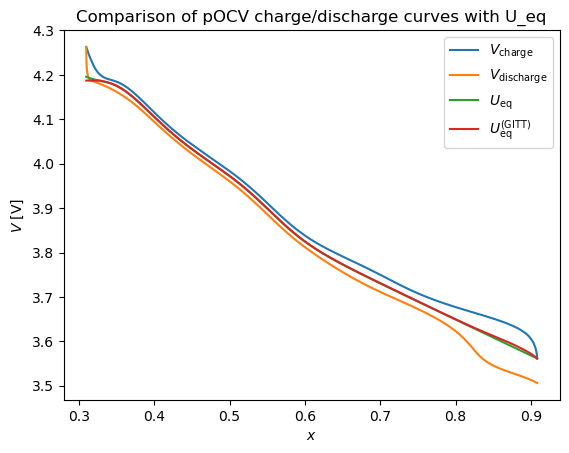

In [13]:
plt.plot(x_charge, V_charge, label=r"$V_{\rm charge}$")
plt.plot(x_discharge, V_discharge, label=r"$V_{\rm discharge}$")
plt.plot(np.sort(x_SI), Ueq_true(np.sort(x_SI)), label=r"$U_{\rm eq}$")
plt.plot(np.sort(x_SI), Ueq_GITT(np.sort(x_SI)), label=r"$U_{\rm eq}^{\rm (GITT)}$")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$V$ [V]")
plt.title("Comparison of pOCV charge/discharge curves with U_eq")
plt.show()

Note that the extrema of the stoichiometries are slightly different for charge and discharge. The U_eq we infer will be the overlap of the two ranges. 

In [14]:
print("minimum stoichiometries:", min(x_charge), min(x_discharge))
print("maximum stoichiometries:",max(x_charge), max(x_discharge))

minimum stoichiometries: 0.30960013736896874 0.30960013736896874
maximum stoichiometries: 0.9083994977301266 0.9083994561468349


In [15]:
# Interpolate charge/discharge voltages
V_charge_int = lambda x: np.interp(x, x_charge[::-1], V_charge[::-1])
V_discharge_int = lambda x: np.interp(x, x_discharge, V_discharge)

In [16]:
x_min = max(min(x_charge), min(x_discharge))
x_max = min(max(x_charge), max(x_discharge))
x_range = np.linspace(x_min, x_max, 1000)
Ueq_pOCV = 0.5*(V_charge_int(x_range) + V_discharge_int(x_range))

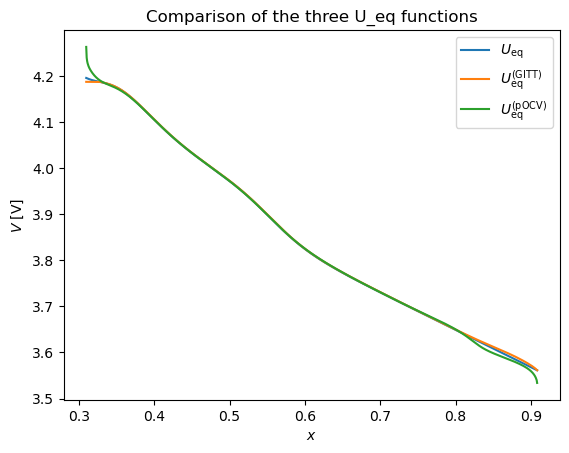

In [17]:
plt.plot(np.sort(x_SI), Ueq_true(np.sort(x_SI)), label=r"$U_{\rm eq}$")
plt.plot(np.sort(x_SI), Ueq_GITT(np.sort(x_SI)), label=r"$U_{\rm eq}^{\rm (GITT)}$")
plt.plot(x_range, Ueq_pOCV, label=r"$U_{\rm eq}^{\rm (pOCV)}$")
plt.title("Comparison of the three U_eq functions")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$V$ [V]")
plt.show()

Finally, write to file

In [18]:
df_pOCV = pd.DataFrame(
    {'x': x_range,
     'pOCV_V': Ueq_pOCV
    }
)

In [19]:
df_pOCV.to_csv(inference_save_dir + 'Ueq_pOCV_simulation.csv', index=False)

$R^2$ comparing to ground truth

In [20]:
print(1-np.mean((Ueq_pOCV - Ueq_true(x_range))**2)/np.var(Ueq_true(x_range)))

0.999253845273535


$R^2$ comparing the one inferred from GITT to ground truth

In [21]:
print(1-np.mean((Ueq_GITT(x_range) - Ueq_true(x_range))**2)/np.var(Ueq_true(x_range)))

0.9999035066984963
